![](https://gamebrott.com/wp-content/uploads/2020/09/store_home_share.jpg)

# Steam Games Review Analysis

##### Steam is the leading PC platform for games. Over its many years online, Steam has amassed a plethora of reviews around its games. These reviews represent a great opportunity to break down the satisfaction and dissatisfaction factors around games and genres, as well sentiment over time.

##### The dataset contains over 6.4 million publicly available reviews in English from Steam Reviews portion of Steam store run by Valve. Each review is described by review text, the id of game it belongs to, review sentiment (positive or negative) and a number of users who thought the review was helpful.

## **1. Import Necessary Libraries and Data**




*In this section, we load our dataset from a CSV file, which contains over 6.4 million reviews from the Steam platform. Due to the vast size of this dataset, we begin our analysis with a manageable sample, specifically 15% of the total data. This sampled dataset is then prepared for further analysis by dropping rows where the review text is missing, as these texts are crucial for our sentiment analysis. We also introduce a new column to count the number of words in each review, providing an initial insight into the dataset's composition.*

In [1]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.0 MB/s eta 0:00:00


In [2]:
#standard
import pandas as pd
import numpy as np
import keras_tuner as kt

# tf and keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

#for class weights
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

#stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# plots
import matplotlib.pyplot as plt
import seaborn as sns


#others
import re
from wordcloud import WordCloud
from collections import Counter
# import keras_tuner as kt
# from kerastuner import HyperModel
# from kerastuner.tuners import RandomSearch
# from kerastuner.engine.hyperparameters import HyperParameters


pd.options.display.max_rows = 10

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# load data
file_path = '/content/drive/My Drive/dataset.csv'
df = pd.read_csv(file_path)
df.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [5]:
# df = pd.read_csv("dataset.csv")
# print('Number of reviews:', df.shape[0])
# print('Unique number of games:', df.app_name.unique().size)
# df.head()

6.4 million rows is a lot of data to work with, will start with a sample of 100k data to start the analysis

In [6]:
sample_size = int(df.shape[0] * 0.25)

# take a random sample, set random_state to 25 so it's reproducible
df_sample = df.sample(n=sample_size, random_state= 25)
print('Number of reviews:', df_sample.shape[0])
print('Unique number of games:', df_sample.app_name.unique().size)
df_sample.head()

Number of reviews: 1604276
Unique number of games: 9036


,app_id,app_name,review_text,review_score,review_votes
3062622,263760,Turbo Dismount,Fun little game where u gotta destroy your veh...,1,0
5038097,387290,Ori and the Blind Forest: Definitive Edition,Best art style I have ever seen in any game. A...,1,0
3693449,294100,RimWorld,Early Access Review,1,0
3441052,282140,SOMA,SOMA is a wonderful game that makes you think ...,1,0
3872170,304050,Trove,"Wait times abolished, gods be praised. but ot...",1,0


In [7]:
# for easier processing later
df = df_sample

In [8]:
# create new dataframe with only 10k row samples of df_sample, then save as sample_dataset_csv
df_sample = df_sample.sample(n=10000)
df_sample.to_csv('sample_dataset.csv')


## **2. Exploratory Data Analysis**


*In the exploratory data analysis (EDA) phase, we delve into the dataset to uncover patterns and insights. We start by examining the basic structure of our data, identifying any missing values and understanding the distribution of review scores. Subsequently, we focus on the most reviewed games, analyzing the balance between positive and negative reviews for these popular titles. Visualizations such as bar plots and word clouds are employed to illustrate these distributions and the common language used in reviews, helping us to grasp the underlying sentiments expressed by gamers.*

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1604276 entries, 3062622 to 224775
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   app_id        1604276 non-null  int64 
 1   app_name      1558391 non-null  object
 2   review_text   1602421 non-null  object
 3   review_score  1604276 non-null  int64 
 4   review_votes  1604276 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 73.4+ MB


**Index Range:** The dataset contains 962,565 entries, ranging from index 0 to 242,8771.

**Non-null Counts:** It lists each column with the number of non-null values, indicating the presence of missing data in 'app_name' and 'review_text'.

**Data Types:** Five columns are present with their data types: one 'int64' type for 'app_id', two 'object' types for 'app_name' and 'review_text', and one 'int64' type for 'review_score'.

**Focus on Review Text:** Blanks in 'app_name' will be ignored as 'review_text' is the primary feature for training.

In [10]:
df.dropna(subset = ['review_text'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1602421 entries, 3062622 to 224775
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   app_id        1602421 non-null  int64 
 1   app_name      1556578 non-null  object
 2   review_text   1602421 non-null  object
 3   review_score  1602421 non-null  int64 
 4   review_votes  1602421 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 73.4+ MB


**Entries Consistency:** All columns now have the same number of non-null entries (961,470), which matches the DataFrame's index range, indicating that rows with missing 'review_text' have been successfully removed.

**Potential Imbalance Inquiry:** With 'review_score' column intact, we can analyze it to check for class imbalance, which is important for understanding the dataset's skewness towards positive or negative reviews and for making informed decisions about model training and evaluation.

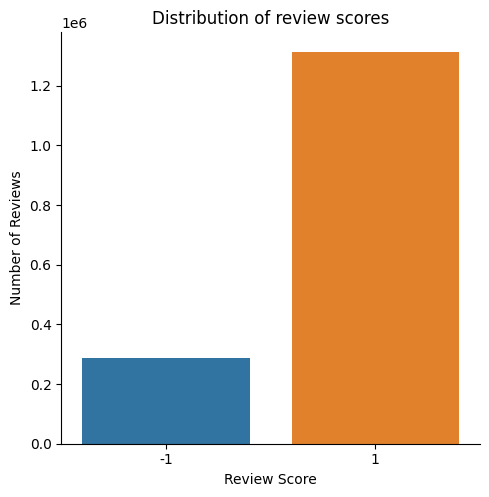

In [11]:
sns.catplot(x='review_score', kind='count', data=df) # plot count of all reviews

# Add legend and labels
plt.grid(False)
plt.title('Distribution of review scores')
plt.ylabel('Number of Reviews')
plt.xlabel('Review Score')

plt.show()

**Imbalance Visualization:** The plot shows a significant difference between the counts of positive (1) and negative (-1) review scores, indicating a class imbalance.

**Prevalence of Positive Reviews:** Positive reviews significantly outnumber negative ones, which could impact the performance of predictive models.

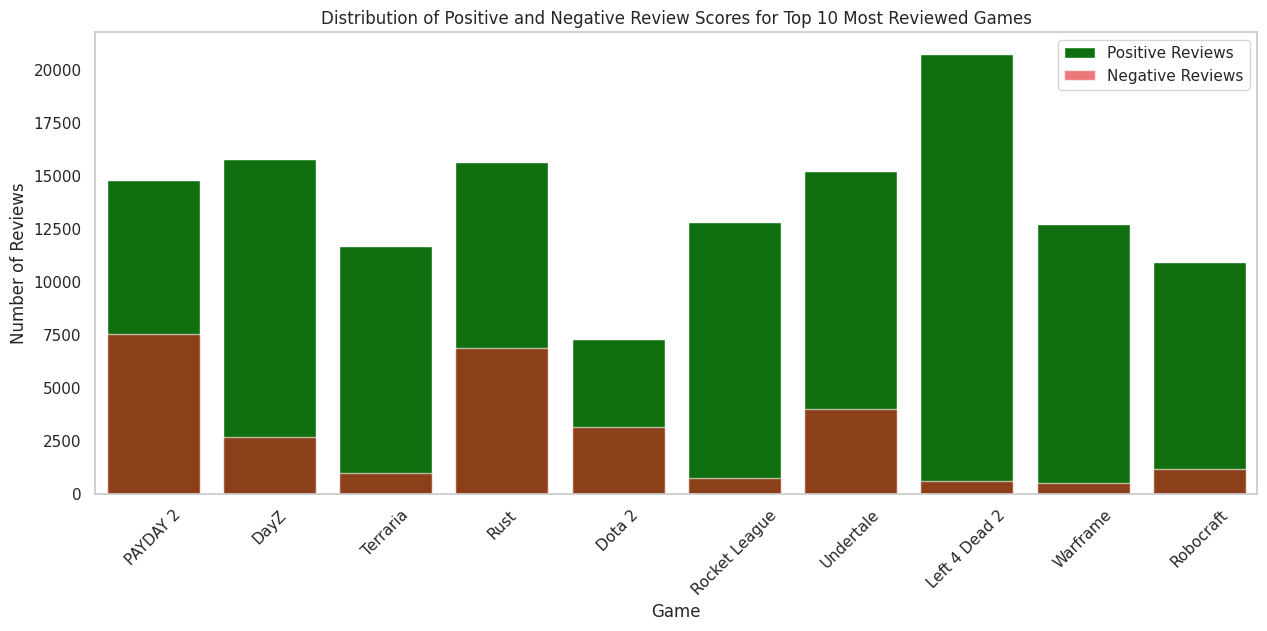

In [12]:
review_counts = df['app_name'].value_counts()

# Get the top 10 most reviewed games
top_10_games = review_counts.head(10)

# Filter the DataFrame to include only the top 10 games
top_10_df = df[df['app_name'].isin(top_10_games.index)]

# Count positive and negative reviews for each game
positive_counts = top_10_df[top_10_df['review_score'] == 1].groupby('app_name').size()
negative_counts = top_10_df[top_10_df['review_score'] == -1].groupby('app_name').size()

# Create a summary DataFrame
summary_df = pd.DataFrame({'Game': top_10_games.index,
                           'Positive': positive_counts,
                           'Negative': negative_counts}).reset_index(drop=True)

# Set plot style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(15, 6))
sns.barplot(x='Game', y='Positive', data=summary_df, color='green', label='Positive Reviews')
sns.barplot(x='Game', y='Negative', data=summary_df, color='red', label='Negative Reviews', alpha=0.6)

# Add legend and labels
plt.grid(False)
plt.legend()
plt.title('Distribution of Positive and Negative Review Scores for Top 10 Most Reviewed Games')
plt.xticks(rotation=45)
plt.ylabel('Number of Reviews')
plt.xlabel('Game')

plt.show()

**Varied Game Reception:** Chart reveals diverse sentiment distribution across popular games.

In [13]:
df['review_text'].value_counts().head(20)

 Early Access Review      253586
   Early Access Review      2712
10/10                       1542
.                           1200
great game                   921
                           ...  
Great Game!                  232
9/10                         209
8/10                         208
Great                        198
i love this game             194
Name: review_text, Length: 20, dtype: int64


The output shows the most frequent review texts in the dataset, indicating that certain phrases like "Early Access Review" and ratings like "10/10" are commonly used by reviewers. This has to be dealt with appropriately in the prepocessor to not add unnecessary noise to the model. Early access review doesn't provide any context as to what the review will be and 10/10 will need to be stored as one token.

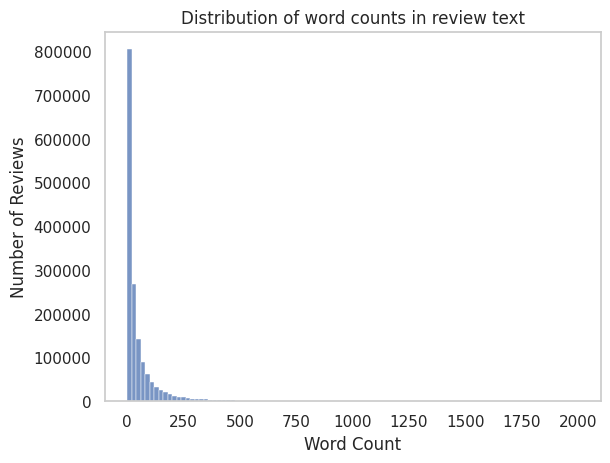

In [14]:
df['word_count'] = df.review_text.apply(lambda s: len(s.split()))
df['word_count'].describe()


sns.histplot(data=df, x="word_count", binwidth=20)

# Add legend and labels
plt.grid(False)
plt.title('Distribution of word counts in review text')
plt.ylabel('Number of Reviews')
plt.xlabel('Word Count')

plt.show()

Most reviews contain relatively few words, with a sharp drop as word count increases, indicacting brevity in user feedback.

In [15]:
print(df['word_count'].describe())
cut_off = np.percentile(df['word_count'], 99.5)
print(cut_off)

count    1.602421e+06
mean     5.546696e+01
std      1.082747e+02
min      0.000000e+00
25%      6.000000e+00
50%      1.900000e+01
75%      5.700000e+01
max      1.990000e+03
Name: word_count, dtype: float64
719.0


Extended Reviews: A small number of reviews are long, with the 99.5th percentile at 718 words, suggesting that while most reviews are concise, there are some extensive ones. We should take this into consideration when model building.

Text(0.5, 1.0, 'Word cloud for Postive Reviews')

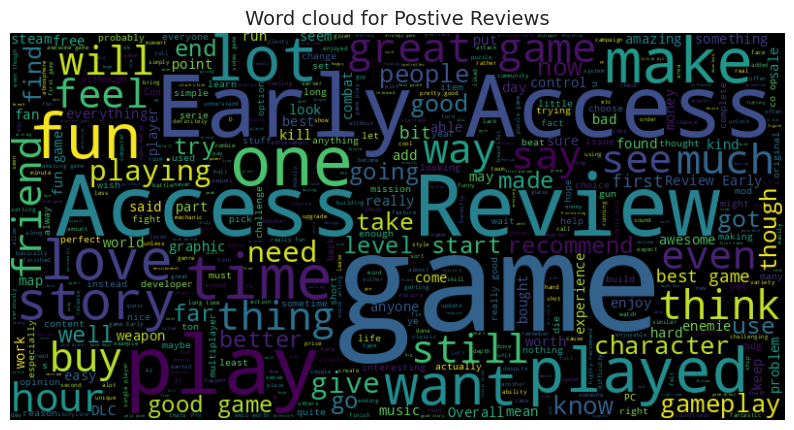

In [16]:
df_positive = df[df.review_score == 1]

plt.figure(figsize = (10,10))
wc = WordCloud(
    max_words = 500,
    width = 800,
    height = 400).generate(" ".join(df_positive.review_text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.title('Word cloud for Postive Reviews',fontsize=14)

## **3. Data Cleaning and Preprocessing**

*This section is dedicated to cleaning and preprocessing the review texts to make them suitable for modeling. We start by removing HTML tags, punctuation, and other non-essential characters while preserving emoticons and certain numeric expressions, as they can convey sentiment. To further refine our dataset, we remove reviews that are overly generic (such as 'early access review') and perform a sentiment mapping, converting negative sentiment scores to a uniform format. This process is critical to ensure the quality and consistency of our data before feeding it into machine learning models.*

Copy Original DataFrame: Create a copy of the original DataFrame to preserve the original data and work on the copy for cleaning.

Review Text Frequency: Analyze the most common review texts to understand common phrases and elements that need special attention in preprocessing

In [17]:
df_clean = df.copy()
df_clean['review_text'].value_counts().head(10)

 Early Access Review      253586
   Early Access Review      2712
10/10                       1542
.                           1200
great game                   921
Great game                   884
Great game!                  606
:)                           532
Nice game                    458
Great Game                   426
Name: review_text, dtype: int64

numbers such as 11/10, 10/10 are important, symbols like :), ʖ are also important.  will keep them and leave them as is in the preprocessor

In [18]:
def preprocessor(text):
    # Replace heart symbols with a placeholder and spaces
    text = re.sub(r"[♥]+", ' **** ', text)

    # Remove HTML markup
    text = re.sub('<[^>]*>', '', text)

    # Extract and store emoticons, ensuring to remove them from the text
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('(?::|;|=)(?:-)?(?:\)|\(|D|P)', '', text)

    # Modify the regular expression to preserve patterns like '10/10'
    # The following regex will avoid replacing slashes between numbers
    text = re.sub(r'(?<!\d)/(?!\d)', ' ', text)

    # Remove non-word characters except for digits and slashes, convert to lowercase
    text = re.sub(r'(?<!\d|\w|/)[\W]+(?!\d|\w|/)', ' ', text.lower())

    # Append emoticons to the end, remove '-' to standardize
    text += ' ' + ' '.join(emoticons).replace('-', '')

    # Collapse multiple spaces into a single space and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [19]:
df_clean['review_text_clean'] = df_clean.review_text.apply(preprocessor)

In [20]:
# df_clean['review_text_clean'].value_counts().head(100).reset_index().iloc[46]
# df_clean['review_text_clean'].value_counts().head(100).reset_index().iloc[23]

#some checks and tests

# df_clean['review_text_clean'].value_counts().head(10)
# df_clean[df_clean['review_text'].str.contains('♥')].head(5)
# df_clean[df_clean['review_text']== '.'].head()
# df_clean[df_clean['review_text_clean']== 'early access review'].review_score.value_counts()
# df_clean[df_clean['review_text_clean']== ''].review_score.value_counts()
# df_clean[df_clean['review_text_clean']== "+1"].review_score.value_counts()
# df_clean[df_clean['review_text_clean']== "11/10"].review_score.value_counts()
# df[df['review_text']== '.'].review_score.value_counts()

Remove specific entries and convert scores.

In [21]:
df_clean = df_clean[df_clean['review_text_clean']!= 'early access review']
df_clean = df_clean[df_clean['review_text_clean'] != '']
df_clean = df_clean[df_clean['review_text_clean'] != '.']
df_clean = df_clean[df_clean['review_text_clean'] != ' early access review']
df_clean = df_clean[df_clean['review_text_clean'] != '  early access review']
df_clean.review_text_clean.value_counts().head(10)

# converting -1 to 0
df_clean.loc[df_clean['review_score']==-1 ,'review_score'] = 0

print('Number of positive reviews:', df_clean[df_clean.review_score.eq(1)].shape[0])
print('Number of negative reviews:', df_clean[df_clean.review_score.eq(0)].shape[0])

Number of positive reviews: 1107363
Number of negative reviews: 234086


data is imbalanced, will use class weights from sklearn and incorporate into training to address that

## **4. Modelling**

*In the model building phase, we construct and train various convolutional neural network (CNN) models to classify reviews into positive or negative sentiments. We start by using a 3-layer CNN similar to what was built in class. We then strrip down the model to something simpler and the model is improved iterativel by adding dropout layers, adjusting the learning rate, and employing regularization techniques to mitigate overfitting. That way we can really diagnose what is substantially improving performance. We also experiment with different architectures, varying the number of layers, filters, and neurons to find the optimal configuration. Model performance is rigorously evaluated using accuracy metrics and confusion matrices.*

<span style="color:chocolate">create TensorFlow dataset</span>

In [22]:
df_final = df_clean.copy()

In [23]:
# define target
target = df_final.pop('review_score') # .pop removes sentiment col from df

# target and review combined tensors
data_tf = tf.data.Dataset.from_tensor_slices(
    (df_final[['review_text_clean']].values, target.values)
)

<span style="color:chocolate">split data into train, validation, and test partitions</span>

In [24]:
# set random seed
tf.random.set_seed(1)

# define splits for training, validation, test
splits=[0.6, 0.2, 0.2]

# shuffle data
data_tf = data_tf.shuffle(
    df_final.shape[0], reshuffle_each_iteration=False)

data_tf_test = data_tf.take(int(df_final.shape[0]*splits[2]))
data_tf_train_valid = data_tf.skip(int(df_final.shape[0]*splits[2]))
data_tf_train = data_tf_train_valid.take(int(df_final.shape[0]*splits[0]))
data_tf_valid = data_tf_train_valid.skip(int(df_final.shape[0]*splits[0]))

``Step 4: Identify unique words (tokens) in the training dataset``

In [25]:
def custom_tokenizer(text):
    # Define a regex pattern to match '10/10', '11/10', '+1'
    pattern = r'\+\d+|\d+/\d+|[:;=]-?[)DPO(/]|[\w\']+'
    tokens = re.findall(pattern, text)
    # remove stop words
    tokens = [token for token in tokens if token.lower() not in stop_words]
    return tokens

token_counts = Counter()

for example in data_tf_train:
    tokens = custom_tokenizer(example[0].numpy()[0].decode('utf-8'))  # Decode if necessary
    token_counts.update(tokens)

print('Size of training vocabulary:', len(token_counts))

# token_counts[':)']
# token_counts['11/10']
# token_counts['+1']

Size of training vocabulary: 313193


In [26]:
# token_counts[':)']
# token_counts['11/10']
# token_counts['+1']
# token_counts['.']

In [27]:
# select 10% of the vocab as token counts
# select 10k as vocab
token_size = int(len(token_counts) * .1)
# token_size = 10000
top_tokens = token_counts.most_common(token_size)

# Create a token-to-index mapping for these tokens
token_to_index = {token: idx + 1 for idx, (token, _) in enumerate(top_tokens)}  # Starting index from 1

In [28]:
def text_to_sequence(text, token_to_index):
    return [token_to_index.get(token, 0) for token in custom_tokenizer(text)]

# Extract features and labels
train_features, train_labels = zip(*[(example[0].numpy()[0].decode('utf-8'), example[1].numpy()) for example in data_tf_train])
valid_features, valid_labels = zip(*[(example[0].numpy()[0].decode('utf-8'), example[1].numpy()) for example in data_tf_valid])
test_features, test_labels = zip(*[(example[0].numpy()[0].decode('utf-8'), example[1].numpy()) for example in data_tf_test])


# Vectorize the text in the dataset
data_tf_train_sequences = [text_to_sequence(feature, token_to_index) for feature in train_features]
data_tf_valid_sequences = [text_to_sequence(feature, token_to_index) for feature in valid_features]
data_tf_test_sequences = [text_to_sequence(feature, token_to_index) for feature in test_features]

In [29]:
max_length = int(cut_off)

data_tf_train_padded = pad_sequences(data_tf_train_sequences, maxlen= max_length, padding='post')
data_tf_valid_padded = pad_sequences(data_tf_valid_sequences, maxlen= max_length, padding='post')
data_tf_test_padded = pad_sequences(data_tf_test_sequences, maxlen= max_length, padding='post')

In [30]:
# this is to get the data balanced later
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels)

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

vocab_size = len(token_to_index) + 1

print(vocab_size)

print(class_weight_dict)

31320
{0: 2.866996038983244, 1: 0.6056191036582338}


In [31]:
def train_evaluate_plot(modelx, weight = class_weight_dict, patience = 3,  learning_rate_schedule = False):

    # Set up early stopping
    early_stopper = EarlyStopping(monitor='val_loss', patience = patience, restore_best_weights=True)

    # Learning Rate Scheduler
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (-epoch / 20))

    # set random seed to get reproductible results
    tf.random.set_seed(1)
    np.random.seed(1)

    if learning_rate_schedule == True:
      history = modelx.fit(
          data_tf_train_padded,
          np.array(train_labels),  # Convert labels to a numpy array
          epochs=20,
          validation_data=(data_tf_valid_padded, np.array(valid_labels)),
          class_weight = weight,
          callbacks=[early_stopper, lr_scheduler]
          )


    else:
      history = modelx.fit(
          data_tf_train_padded,
          np.array(train_labels),  # Convert labels to a numpy array
          epochs=20,
          validation_data=(data_tf_valid_padded, np.array(valid_labels)),
          class_weight = weight,
          callbacks=[early_stopper]
          )

    print()
    print("test accuracy: ", modelx.evaluate(data_tf_test_padded, np.array(test_labels))[1])
    print()

    # plot
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    ax.set_ylim(0,1)
    plt.show()


def plot_confusion_matrix(modelx , valid_labels):

    predictions = modelx.predict(data_tf_valid_padded)

    # Since your final layer is a sigmoid, you'll need to convert these predictions to binary (0 or 1).
    # The default threshold is 0.5, but you can adjust it based on your needs.
    threshold = 0.5
    binary_predictions = np.where(predictions > threshold, 1, 0)

    # Now we have the binary predictions, we can generate the confusion matrix.
    # The true labels should be in the same shape as binary_predictions.
    conf_matrix = confusion_matrix(np.array(valid_labels), binary_predictions)

    # Normalize the confusion matrix so that each row sums to 1.
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Now, let's plot the normalized confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))  # You can adjust the size of the figure here
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', ax=ax, cmap='Blues', square=True)

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted labels', fontdict=label_font);
    ax.set_ylabel('True labels', fontdict=label_font);
    ax.set_title('Normalized Confusion Matrix', fontdict=label_font);
    ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Negative', 'Positive']);  # Adjust to your class names
    ax.yaxis.set_ticklabels(['Negative', 'Positive']);  # Adjust to your class names

    plt.show()

# **Model 1**
**1.** 3 layer CNN as shown in class demo

**2.** Utilizes a high-dimensional embedding layer

**3.** Aggressive dropout strategy

In [32]:
# Convolutional Neural Network Model Building
def build_cnn_model(vocab_size, embedding_dim, input_length, class_weight_dict):
    # Clear any previous model from memory
    tf.keras.backend.clear_session()
    tf.random.set_seed(1)  # for reproducibility

    # Model architecture
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=input_length),
        tf.keras.layers.Conv1D(128, 3,padding = "same", activation='relu'),
        tf.keras.layers.MaxPooling1D(5),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Conv1D(64, 5,padding = "same", activation='relu'),
        tf.keras.layers.MaxPooling1D(5),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Conv1D(32, 7,padding = "same", activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    model.summary()
    return model

# Define parameters
vocab_size = len(token_to_index) + 1  # From token_to_index mapping
embedding_dim = 128  # Or any other suitable value
input_length = max_length  # From data_tf_train_padded

# Build model
cnn_model = build_cnn_model(vocab_size, embedding_dim, input_length, class_weight_dict)

# Early stopping and learning rate scheduler
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (-epoch / 20))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 719, 128)          4008960   
                                                                 
 conv1d (Conv1D)             (None, 719, 128)          49280     
                                                                 
 max_pooling1d (MaxPooling1  (None, 143, 128)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 143, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 143, 64)           41024     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 28, 64)            0         
 g1D)                                                   

Epoch 1/20
25153/25153 [==============================] - 257s 10ms/step - loss: 0.3705 - accuracy: 0.8348 - val_loss: 0.3529 - val_accuracy: 0.8341 - lr: 0.0010
Epoch 2/20
25153/25153 [==============================] - 163s 6ms/step - loss: 0.3217 - accuracy: 0.8592 - val_loss: 0.3111 - val_accuracy: 0.8522 - lr: 8.9125e-04
Epoch 3/20
25153/25153 [==============================] - 159s 6ms/step - loss: 0.3015 - accuracy: 0.8694 - val_loss: 0.3343 - val_accuracy: 0.8578 - lr: 7.9433e-04
Epoch 4/20
25153/25153 [==============================] - 160s 6ms/step - loss: 0.2858 - accuracy: 0.8751 - val_loss: 0.3314 - val_accuracy: 0.8615 - lr: 7.0795e-04
Epoch 5/20
8385/8385 [==============================] - 21s 3ms/step - loss: 0.3103 - accuracy: 0.8518
Test accuracy: 0.8518165349960327


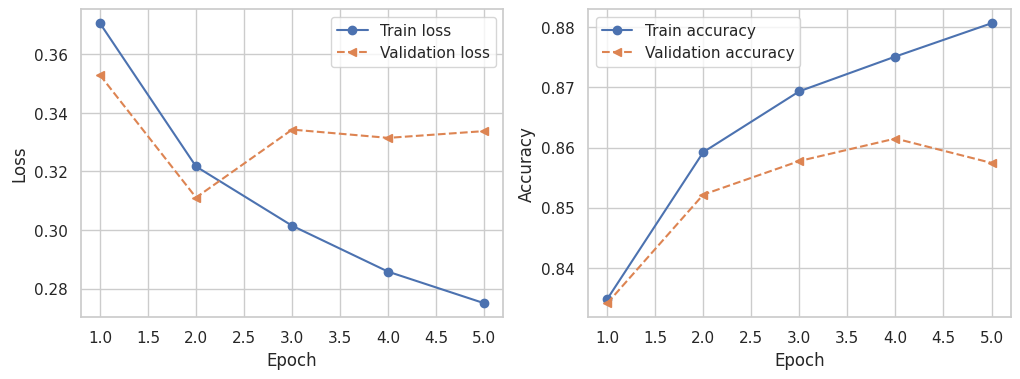

8385/8385 [==============================] - 16s 2ms/step


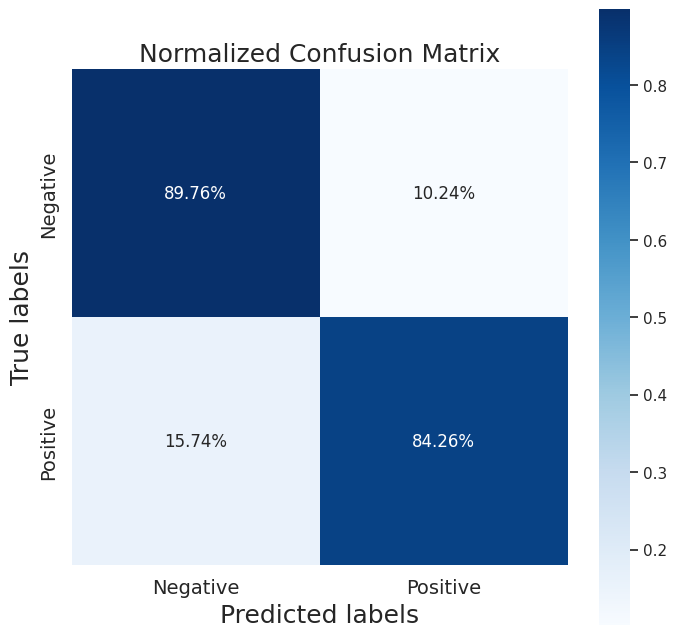

In [33]:
# Train the model
history = cnn_model.fit(
    data_tf_train_padded,
    np.array(train_labels),
    epochs=20,
    validation_data=(data_tf_valid_padded, np.array(valid_labels)),
    class_weight=class_weight_dict,
    callbacks=[early_stopper, lr_scheduler]
)

# Evaluate model performance
test_accuracy = cnn_model.evaluate(data_tf_test_padded, np.array(test_labels))[1]
print(f"Test accuracy: {test_accuracy}")

# Plot training history
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(x_arr, hist['loss'], '-o', label='Train loss')
ax[0].plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(x_arr, hist['accuracy'], '-o', label='Train accuracy')
ax[1].plot(x_arr, hist['val_accuracy'], '--<', label='Validation accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

# Plot confusion matrix
plot_confusion_matrix(cnn_model, valid_labels)


### **Model 1 Interpretation:**

**Overfitting:** The model is learning the training data too well, leading to a decrease in validation performance as indicated by the increasing validation loss and fluctuating validation accuracy.

**Early Stopping Triggered:** The training stops early due to a lack of improvement in validation loss, suggesting that the model is unable to learn further generalized features from the data.

---

# **Model 2**
**1.** Simple model 2 layers. Stripping down the complexity.

**2.** Simplet embedding with 64 dimmensions.

**3.** No Dropout Layers

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 719, 64)           2004480   
                                                                 
 conv1d_3 (Conv1D)           (None, 715, 128)          41088     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 143, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 139, 128)          82048     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 27, 128)           0         
 g1D)                                                            
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)              

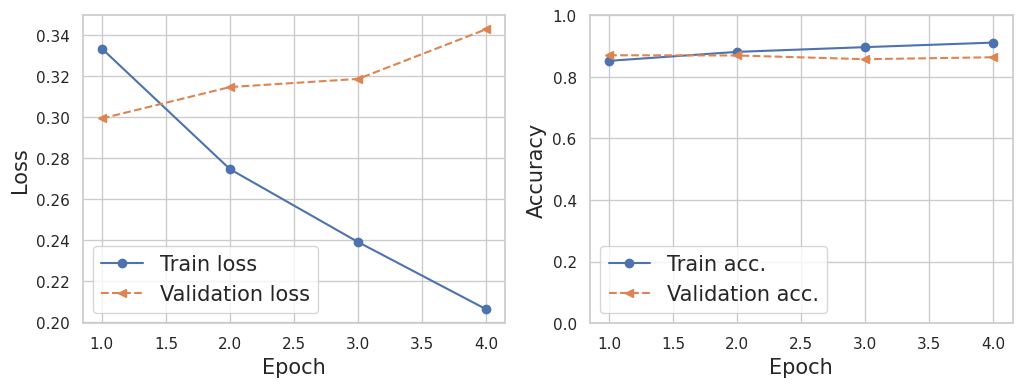



8385/8385 [==============================] - 14s 2ms/step


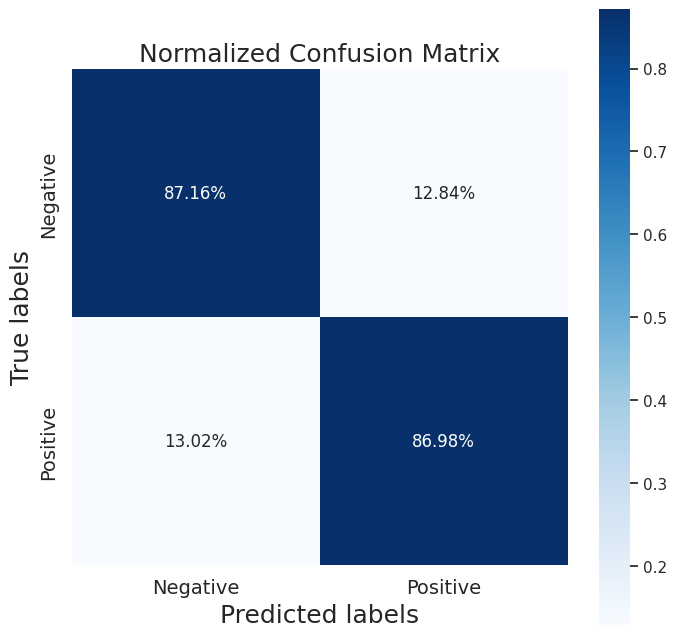

In [34]:
# Model architecture
model = Sequential()
model.add(Embedding(vocab_size, 64, input_length=max_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# Compilation
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])



# Train, evaluate, and plot
train_evaluate_plot(model , weight = class_weight_dict)
print()

# plot confusion matrix
print()
plot_confusion_matrix(model , valid_labels)

### **Model 2 Interpretation:**



**Validation Loss Inconsistency:** The validation loss is not consistently decreasing and shows volatility across epochs, which may suggest the model is not stable in terms of learning from the validation set.

**Accuracy Plateau:** Both training and validation accuracies plateau early in the training process, indicating that the model might have reached its learning capacity with the current architecture and data.

**Potential Overfitting:** There is a noticeable gap between training and validation accuracy, with training accuracy being higher, which could be a sign of overfitting. Despite the simpler model, it seems to memorize the training data to some extent rather than learning to generalize.

**Improved General Performance:** Despite the issues, this model has a better test accuracy compared to the more complex model previously analyzed, indicating a more generalizable performance on unseen data.

---

# **Model 3**

**1.** Embedding layer with 0.2 dropout

**2.** Two 128-filter Conv1D layers.

**3.** Dropout layers for complexity control.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 719, 64)           2004480   
                                                                 
 dropout_3 (Dropout)         (None, 719, 64)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 715, 128)          41088     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 143, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 139, 128)          82048     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 27, 128)           0         
 g1D)                                                 

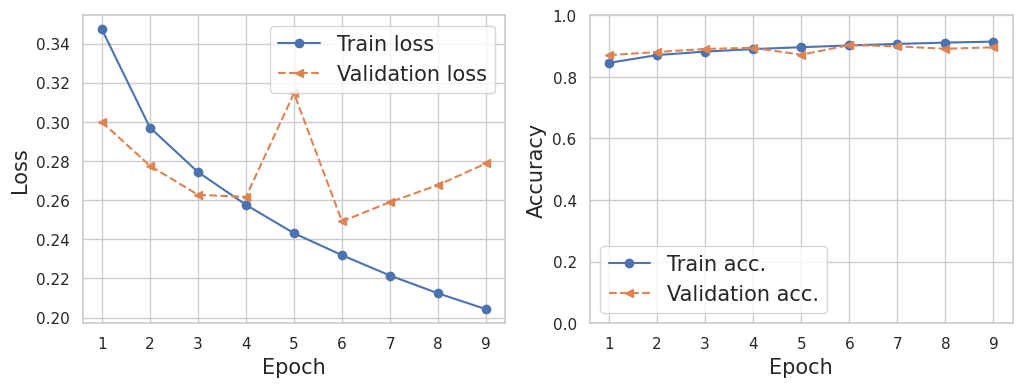



8385/8385 [==============================] - 14s 2ms/step


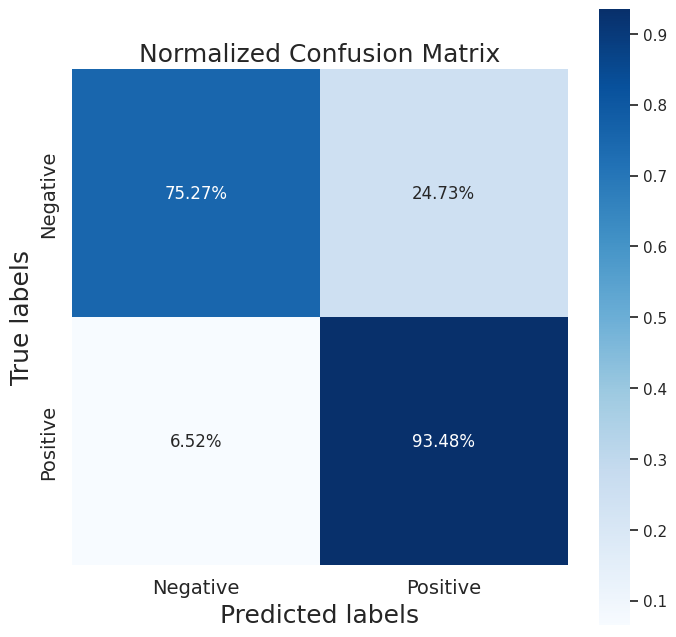

In [35]:
# Model architecture
model = Sequential()
model.add(Embedding(vocab_size, 64, input_length=max_length))
# Dropout layer after embedding
model.add(Dropout(0.2))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
# Dropout layer after dense layer
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()


# Compilation
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


# Train, evaluate, and plot
train_evaluate_plot(model , weight = class_weight_dict, learning_rate_schedule = True)
print()

# plot confusion matrix
print()
plot_confusion_matrix(model , valid_labels)

### **Model 3 Interpretation:**

**Stabilizing Loss and Accuracy:** The training and validation loss are converging, and the validation accuracy stabilizes alongside training accuracy, suggesting that the model's learning is more balanced and generalizing better than the previous models.

**Lower Overfitting Indicators:** The inclusion of dropout layers after the embedding and before the output layer appears to be effective, as indicated by the smaller gap between training and validation accuracy, which suggests reduced overfitting compared to previous iterations.

**Imbalance in Classification:** The confusion matrix indicates a disparity in the model's performance across different classes, with a higher accuracy in predicting positive reviews compared to negative reviews, suggesting a potential bias or imbalance in the model's ability to equally represent both classes.

---



# **Model 4**

**1.** Embedding and dense layers with increased dropout

**2.** L2 regularization on the dense layer.

**3.** Increased weight for the negative class.

In [36]:
class_weight_dict

class_weight_dict_adj = {0 : class_weight_dict[0] * 1.5 , 1 : class_weight_dict[1]}

class_weight_dict_adj

{0: 4.300494058474866, 1: 0.6056191036582338}

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 719, 64)           2004480   
                                                                 
 dropout_5 (Dropout)         (None, 719, 64)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 715, 128)          41088     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 143, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, 141, 128)          49280     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 28, 128)           0         
 g1D)                                                 

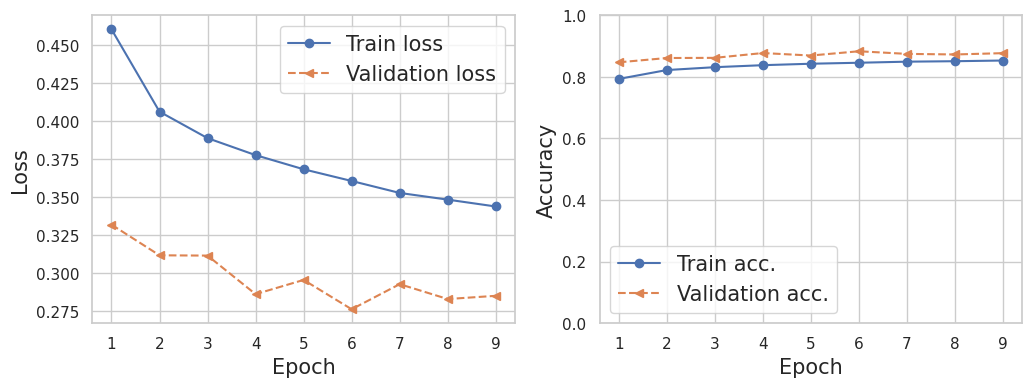



8385/8385 [==============================] - 14s 2ms/step


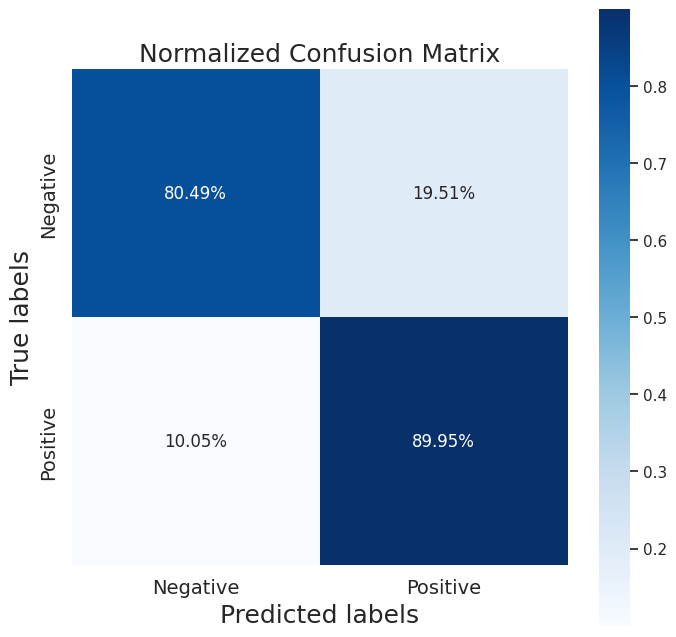

In [37]:
# Adjusted Model architecture
model = Sequential()
model.add(Embedding(vocab_size, 64, input_length=max_length))
# increased drop out
model.add(Dropout(0.4))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(5))
model.add(GlobalMaxPooling1D())
#added regularization
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
# increased drop out
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# Compilation
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


# Train, evaluate, and plot
train_evaluate_plot(model , weight = class_weight_dict_adj, learning_rate_schedule = True)
print()

# plot confusion matrix
print()
plot_confusion_matrix(model , valid_labels)

### **Model 4 Interpretation:**

**Decreased Test Accuracy:** There is a slight decline in test accuracy, suggesting that the model's increased regularization and higher dropout may have led to underfitting, compromising its ability to generalize to unseen data.

**Higher Initial Loss:** The model starts with a higher initial loss compared to the previous model, which could indicate that the increased dropout and regularization are initially making it harder for the model to fit the data.

**Better Balance in Classification:** The normalized confusion matrix shows a slightly more balanced performance in correctly predicting both negative and positive labels compared to the previous model, although there is still room for improvement in correctly classifying negative reviews.

---



# **Model 5**
**1.** 0.4 before Conv1D, 0.6 before output.

**2.** Conv1D layers with 48 and 64 filters.

**3.** Batch Normalization: Applied post convolutional layers.

**4.** Reduced Complexity: Fewer filters, smaller dense layer.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 719, 64)           2004480   
                                                                 
 dropout_7 (Dropout)         (None, 719, 64)           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 715, 48)           15408     
                                                                 
 batch_normalization (Batch  (None, 715, 48)           192       
 Normalization)                                                  
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 143, 48)           0         
 g1D)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 141, 64)          

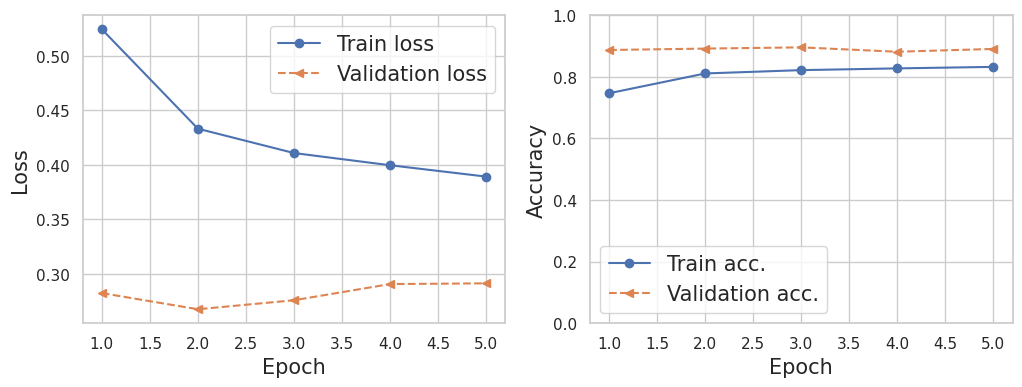



8385/8385 [==============================] - 15s 2ms/step


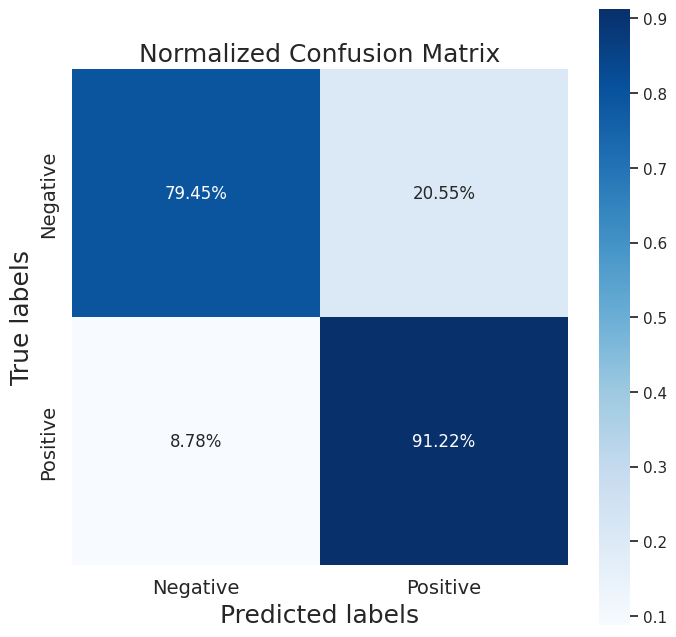

In [38]:
# Adjusted Model architecture
model = Sequential()
model.add(Embedding(vocab_size, 64, input_length=max_length))
model.add(Dropout(0.4))
# decrease filter
model.add(Conv1D(48, 5, activation='relu'))
# Batch normalization layer after conv layer
model.add(BatchNormalization())
model.add(MaxPooling1D(5))
# decrease filter
model.add(Conv1D(64, 3, activation='relu'))
# Batch normalization layer after conv layer
model.add(BatchNormalization())
model.add(MaxPooling1D(5))
model.add(GlobalMaxPooling1D())
#decrease dense layer
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# Compilation
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


# Train, evaluate, and plot
train_evaluate_plot(model , weight = class_weight_dict_adj, learning_rate_schedule = True)
print()

# plot confusion matrix
print()
plot_confusion_matrix(model , valid_labels)

### **Model 5 Interpretation:**

**Improved Validation Accuracy:** This model exhibits an increase in validation and test accuracy compared to the previous iteration, suggesting better generalization capabilities.

**Reduced Overfitting:** The loss graphs indicate a closer convergence between the training and validation loss, implying a reduction in overfitting, possibly due to the model's simplified architecture and increased regularization.

**Consistency in Classification Performance:** The normalized confusion matrix shows a similar performance in classifying positive reviews, with a minor increase in the correct classification of negative reviews and decrease in negative correct prerdictions

---



# **5. Hyperparameter Tuning and non-neural network model.**

*Here, we shift our focus to hyperparameter tuning, utilizing Keras Tuner to explore a range of configurations for our CNN models. The tuning process involves adjusting various parameters like embedding dimensions, number of convolutional layers, filters, and kernel sizes. This systematic search helps us to identify the best-performing model configuration. Additionally, we explore a different machine learning approach using Linear SVC, a support vector classifier, trained on TF-IDF vectors of our text data, offering a comparative view on model performance.*

In [39]:
# def build_model(hp):
#     model = Sequential()
#     # Tuning the embedding dimensions
#     model.add(Embedding(input_dim=vocab_size,
#                         output_dim=hp.Int('embedding_dim', min_value=16, max_value=64, step=16),
#                         input_length=max_length))
#     model.add(Dropout(0.4))

#     # Assume the input length for the first conv layer is max_length
#     input_length = max_length

#     # Tuning the number of convolutional layers
#     for i in range(hp.Int('num_conv_layers', 2, 4)):
#         # Tuning the number of filters and kernel size in convolutional layers
#         filters = hp.Int('filters_conv_' + str(i), min_value=16, max_value=64, step=16)
#         kernel_size = hp.Int('kernel_size_conv_' + str(i), min_value=3, max_value=7, step=2)
#         model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
#         model.add(BatchNormalization())

#         # Calculate the size of the output after the conv layer to adjust the pooling size
#         # This is a simple calculation, you may need a more complex one depending on strides, padding, etc.
#         conv_output_length = input_length - kernel_size + 1
#         pool_size = min(5, conv_output_length)  # Ensure the pool size is not too big

#         model.add(MaxPooling1D(pool_size))
#         input_length = conv_output_length // pool_size  # Update the input length for the next layer

#     model.add(GlobalMaxPooling1D())

#     # Tuning the size of dense layers
#     model.add(Dense(units=hp.Int('units_dense', min_value=16, max_value=64, step=16),
#                     activation='relu',
#                     kernel_regularizer=l2(0.01)))

#     model.add(Dropout(0.6))
#     model.add(Dense(1, activation='sigmoid'))

#     model.compile(optimizer=Adam(learning_rate=0.001),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])

#     return model


# # Callbacks
# early_stopper = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (-epoch / 20))

# # Create a tuner
# tuner = kt.Hyperband(
#     build_model,
#     objective='val_accuracy',
#     max_epochs=20,
#     hyperband_iterations=2,
#     directory='my_dir',
#     project_name='parameter_searching_2'
# )

# # Start searching for the best hyperparameters
# tuner.search(
#     data_tf_train_padded,
#     np.array(train_labels),
#     epochs=20,
#     validation_data=(data_tf_valid_padded, np.array(valid_labels)),
#     class_weight=class_weight_dict_adj,
#     callbacks=[early_stopper, lr_scheduler]
# )

# Trial 24 Complete [00h 17m 08s]
# val_accuracy: 0.891758143901825

# Best val_accuracy So Far: 0.9078245162963867
# Total elapsed time: 04h 34m 07s

# Search: Running Trial #25

# Value             |Best Value So Far |Hyperparameter
# 48                |48                |embedding_dim
# 3                 |3                 |num_conv_layers
# 48                |32                |filters_conv_0
# 3                 |7                 |kernel_size_conv_0
# 32                |48                |filters_conv_1
# 3                 |3                 |kernel_size_conv_1
# 16                |16                |units_dense
# 16                |16                |filters_conv_2
# 7                 |7                 |kernel_size_conv_2
# 32                |64                |filters_conv_3
# 7                 |7                 |kernel_size_conv_3
# 20                |7                 |tuner/epochs
# 7                 |3                 |tuner/initial_epoch
# 1                 |2                 |tuner/bracket
# 1                 |1                 |tuner/round
# 0018              |0005              |tuner/trial_id

# Epoch 8/20
#   342/15096 [..............................] - ETA: 22:40 - loss: 0.4874 - accuracy: 0.8543

# **Hyper Tuned Model**
**1.** Tailored Convolution Layers: Three convolutional layers with hyperparameter-tuned filters and kernel sizes for optimal feature extraction.

**2.** Optimized Embedding: Embedding layer with tuned 48 dimensions.

**3.** Targeted Regularization: Strategic dropout and L2 regularization applied to combat overfitting and ensure robustness.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 719, 48)           1503360   
                                                                 
 dropout_9 (Dropout)         (None, 719, 48)           0         
                                                                 
 conv1d_11 (Conv1D)          (None, 717, 48)           6960      
                                                                 
 batch_normalization_2 (Bat  (None, 717, 48)           192       
 chNormalization)                                                
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 143, 48)           0         
 ng1D)                                                           
                                                                 
 conv1d_12 (Conv1D)          (None, 141, 32)          

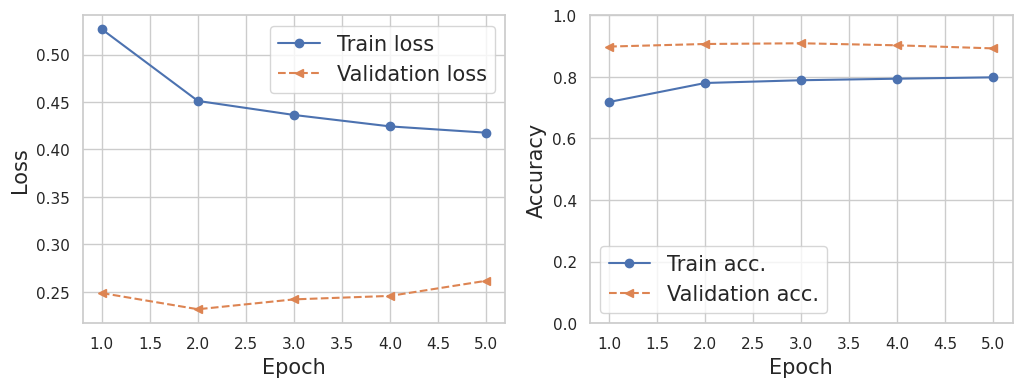

8385/8385 [==============================] - 16s 2ms/step


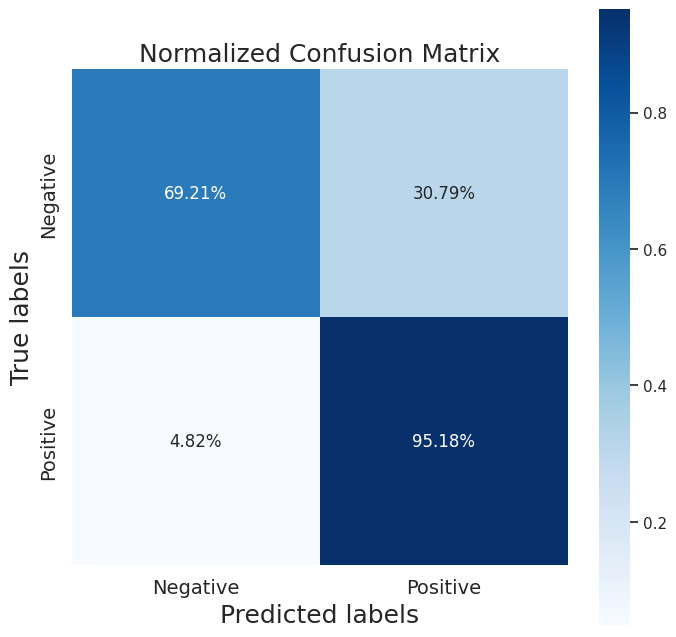

In [40]:
# Adjusted Model architecture based on hyperparameter tuning
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=48, input_length=max_length))  # embedding_dim: 48
model.add(Dropout(0.4))

# First Convolutional Layer - Trial 24 settings
model.add(Conv1D(filters=48, kernel_size=3, activation='relu'))  # filters_conv_0: 48, kernel_size_conv_0: 3
model.add(BatchNormalization())
model.add(MaxPooling1D(5))

# Second Convolutional Layer - Trial 24 settings
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))  # filters_conv_1: 32, kernel_size_conv_1: 3
model.add(BatchNormalization())
model.add(MaxPooling1D(5))

# Third Convolutional Layer - Since num_conv_layers is 3, we add another Conv1D
model.add(Conv1D(filters=16, kernel_size=7, activation='relu'))  # filters_conv_2: 16, kernel_size_conv_2: 7
model.add(BatchNormalization())
model.add(MaxPooling1D(5))

model.add(GlobalMaxPooling1D())

# Dense Layer
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))  # units_dense: 16
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

model.summary()

# Compilation
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Here, replace 'train_evaluate_plot' with your actual training and evaluation function.
# The 'class_weight_dict_adj' should be replaced with the actual class weights you've calculated.
# 'learning_rate_schedule' should be set according to your preference or previous setup.

# Train, evaluate, and plot
train_evaluate_plot(model, weight=class_weight_dict_adj, learning_rate_schedule=True)

# Plot confusion matrix
# Replace 'plot_confusion_matrix' with your actual function for plotting the confusion matrix.
# The 'valid_labels' should be the validation labels from your dataset.
plot_confusion_matrix(model, valid_labels)

### **HyperTunned CNN Model Interpretation:**

**Highest Test Accuracy:** Achieves the best test accuracy of all models evaluated so far.

**Volatile Validation Loss:** Shows an initial decrease in validation loss, but subsequent volatility.

**Significant Positive Bias**: Confusion matrix indicates a high true positive rate, but struggles with true negatives relatively.

---



## SVC Model

**TF-IDF Vectorization:** Converts text to numerical data using TF-IDF.

**SVM Implementation:** Uses Linear SVC for classification.

**Full Data Utilization:** Trains on combined dataset features.

**Accuracy Assessment:** Evaluates with train, validation, and test splits.

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine train, validation, and test features for TF-IDF
combined_text = train_features + valid_features + test_features

# Create and fit TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=None)  # Adjust max_features as needed
tfidf_vectorizer.fit(combined_text)

# Transform text data to TF-IDF
X_train_tfidf = tfidf_vectorizer.transform(train_features)
X_valid_tfidf = tfidf_vectorizer.transform(valid_features)
X_test_tfidf = tfidf_vectorizer.transform(test_features)

# Labels are already prepared in train_labels, valid_labels, test_labels


In [42]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Create and train the LinearSVC model
clf = LinearSVC()
clf.fit(X_train_tfidf, train_labels)

# Predictions for evaluation
train_preds = clf.predict(X_train_tfidf)
valid_preds = clf.predict(X_valid_tfidf)
test_preds = clf.predict(X_test_tfidf)

# Evaluate the model
accuracy_train = accuracy_score(train_labels, train_preds)
accuracy_valid = accuracy_score(valid_labels, valid_preds)
accuracy_test = accuracy_score(test_labels, test_preds)

print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Valid Accuracy: {accuracy_valid:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")


Train Accuracy: 0.9296
Valid Accuracy: 0.9051
Test Accuracy: 0.9051


In [43]:
from sklearn.model_selection import cross_val_score

# Combine training and validation data for cross-validation
X_train_valid_tfidf = tfidf_vectorizer.transform(train_features + valid_features)
y_train_valid = train_labels + valid_labels

# Perform cross-validation
cv_scores = cross_val_score(clf, X_train_valid_tfidf, y_train_valid, cv=5)  # Adjust the number of folds as needed

print(f"Cross-Validation Mean Accuracy: {cv_scores.mean():.4f}")


Cross-Validation Mean Accuracy: 0.9061


### **SVC Model Interpretation:**

**High Training Accuracy:** The model shows excellent performance on the training data, suggesting good learning capacity.

**Consistent Generalization:** Validation and test accuracies are very close, indicating consistent performance on unseen data.

**Cross-Validation Confirmation:** Cross-validation confirms the model's robustness with a mean accuracy similar to the test accuracy.

**Efficient Computation:** Model requires significantly less time to train and predict.

---



## Ethical Considerations


In the process of analyzing Steam game reviews through machine learning, several ethical challenges come to light. One such issue is the bias in data representation, as the dataset is primarily composed of English reviews, which does not adequately reflect the diverse languages and cultures of the global gaming community. The potential effects on game developers and publishers are also significant, as any misinterpretation of sentiment analysis could harm their reputation and sales. Issues of data privacy and consent are raised, given that users may not be aware that their publicly posted reviews are being analyzed. Additionally, the dependence on automated analysis could miss subtle aspects and context inherent in human language, potentially leading to distorted results. Lastly, without demographic information of reviewers we lose the ability of understanding how different groups perceive games.

##Conclusions

The analysis of  Steam game reviews using machine learning models like CNNs and Linear SVC revealed key insights into gaming sentiments and preferences. CNNs, especially the HyperTunned CNN Model, were highly accurate in review classification, affirming deep learning's efficacy in handling large text datasets. However, the Linear SVC model, trained on TF-IDF vectors, also achieved comparable accuracy, offering a simpler, more computationally efficient alternative. This makes SVC particularly recommendable as it performs robustly against the baseline accuracy of 83% (assuming all reviews are positive) while being less complex and resource-intensive than CNNs. The analysis uncovered consistent sentiment trends and expression patterns among gamers. Despite high accuracy, challenges in classifying negative reviews and fluctuating validation losses were noted, underscoring the need for ongoing refinement in sentiment analysis models. These findings can guide game developers in understanding public opinion and shaping future strategies. Future research should focus on multilingual analysis, more nuanced sentiment classifications, demographic impacts, and integrating user engagement metrics for a fuller picture of game reception and popularity.